# 1. Import the necessary packages

In [1]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream

import numpy as np
import imutils
import time
import cv2
import os

# import dependencies for colab webcam
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import PIL
import io
import html

# Defining functions for face and mask detection

In [2]:
def detect_and_predict_mask(frame, faceNet, maskNet):





	# grab the dimensions of the frame and then construct a blob
	# from it
	(h, w) = frame.shape[:2]
	blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
	faceNet.setInput(blob)
	detections = faceNet.forward()
	print(detections.shape)




	# initialize our list of faces, their corresponding locations,
	# and the list of predictions from our face mask network
	faces = []
	locs = []
	preds = []

	# loop over the detections
	for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
		confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
		if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
			box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
			(startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
			(startX, startY) = (max(0, startX), max(0, startY))
			(endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
			face = frame[startY:endY, startX:endX]
			face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
			face = cv2.resize(face, (224, 224))
			face = img_to_array(face)
			face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
			faces.append(face)
			locs.append((startX, startY, endX, endY))

	# only make a predictions if at least one face was detected
	if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
		faces = np.array(faces, dtype="float32")
		preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
	return (locs, preds)


In [3]:
def detect_face(frame,faceNet):
  # grab the dimensions of the frame and then construct a blob
	# from it
  (h, w) = frame.shape[:2]
  blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),
		(104.0, 177.0, 123.0))

	# pass the blob through the network and obtain the face detections
  faceNet.setInput(blob)
  detections = faceNet.forward()
  print(detections.shape)

  # loop over the detections
  for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the detection'
    confidence = detections[0, 0, i, 2]
    if confidence < 0.5:
      return 0
    else:
      return 1


In [4]:
def measure_distance(frame,faceNet):
  (h, w) = frame.shape[:2]
  blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),(104.0, 177.0, 123.0))

  faceNet.setInput(blob)
  detections = faceNet.forward()
  print(detections.shape)

  # loop over the detections
  for i in range(0, detections.shape[2]):
		# extract the confidence (i.e., probability) associated with
		# the detection
    confidence = detections[0, 0, i, 2]

		# filter out weak detections by ensuring the confidence is
		# greater than the minimum confidence
    if confidence > 0.5:
			# compute the (x, y)-coordinates of the bounding box for
			# the object
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")

			# ensure the bounding boxes fall within the dimensions of
			# the frame
      (startX, startY) = (max(0, startX), max(0, startY))
      (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

			# extract the face ROI, convert it from BGR to RGB channel
			# ordering, resize it to 224x224, and preprocess it
      face = frame[startY:endY, startX:endX]
      face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      face = cv2.resize(face, (224, 224))
      face = img_to_array(face)
      face = preprocess_input(face)

			# add the face and bounding boxes to their respective
			# lists
      faces.append(face)
      locs.append((startX, startY, endX, endY))  

# only make a predictions if at least one face was detected
  if len(faces) > 0:
		# for faster inference we'll make batch predictions on *all*
		# faces at the same time rather than one-by-one predictions
		# in the above `for` loop
    faces = np.array(faces, dtype="float32")
    preds = maskNet.predict(faces, batch_size=32)

	# return a 2-tuple of the face locations and their corresponding
	# locations
  return (locs, preds)


#Loading the face detector model and mask detector model

In [5]:
# load our serialized face detector model from disk

prototxtPath = r"/content/drive/MyDrive/face mask detection/face_detector/deploy.prototxt"
weightsPath = r"/content/drive/MyDrive/face mask detection/face_detector/res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
maskNet = load_model("/content/drive/MyDrive/face mask detection/mask_detector.model")


In [6]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## Running code on webcam video is a little more complex than images. We need to start a video stream using our webcam as input. Then we run each frame through our progam (face detection) and create an overlay image that contains bounding box of detection(s). We then overlay the bounding box image back onto the next frame of our video stream.

In [7]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

#Performing face mask detection 


[INFO] starting video stream...


<IPython.core.display.Javascript object>

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 8s 8s/step


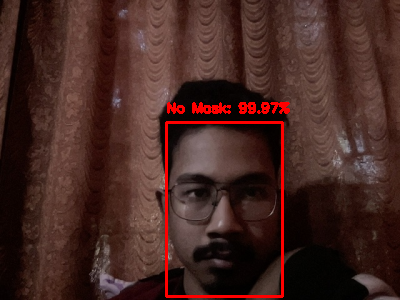

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 20ms/step


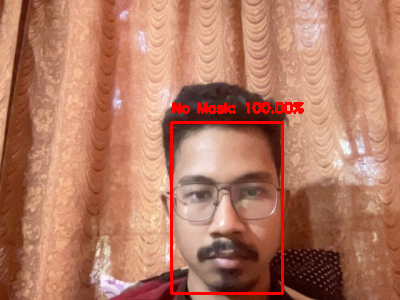

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 21ms/step


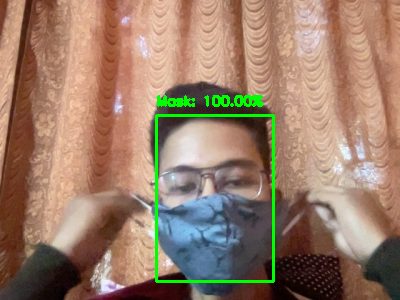

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 20ms/step


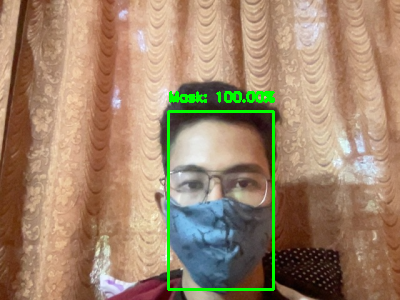

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 20ms/step


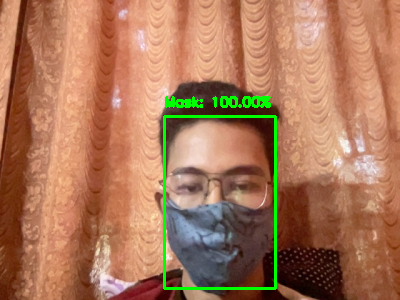

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 22ms/step


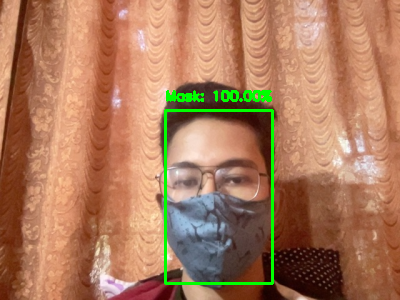

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 45ms/step


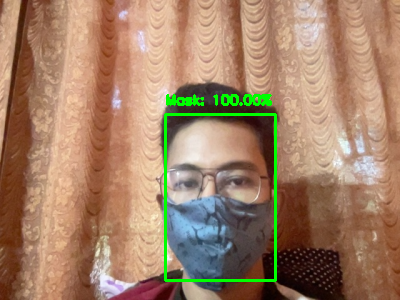

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 20ms/step


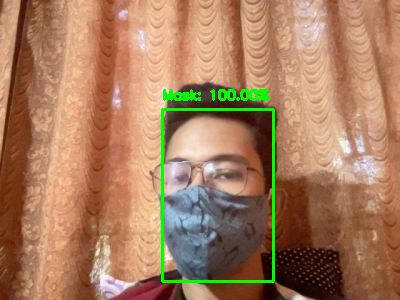

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 21ms/step


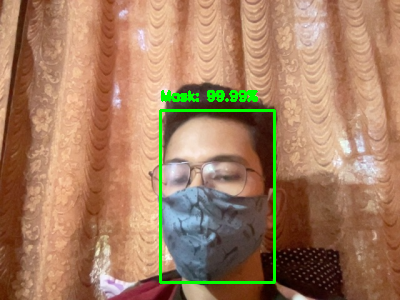

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 21ms/step


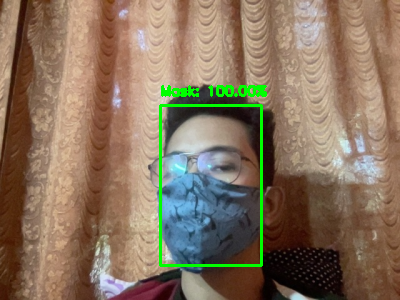

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 20ms/step


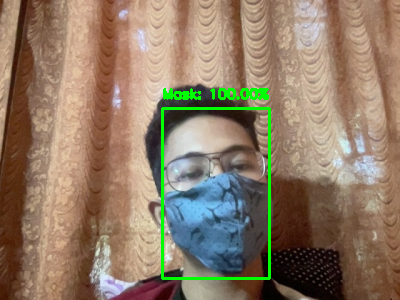

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 19ms/step


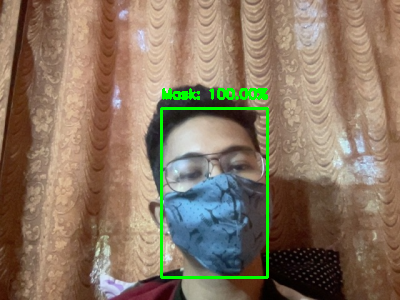

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 23ms/step


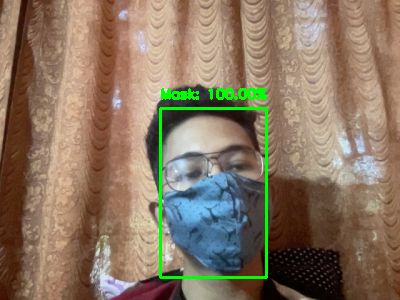

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 26ms/step


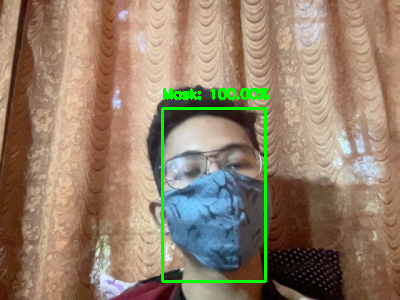

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 20ms/step


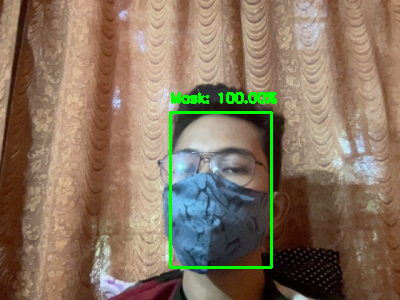

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 21ms/step


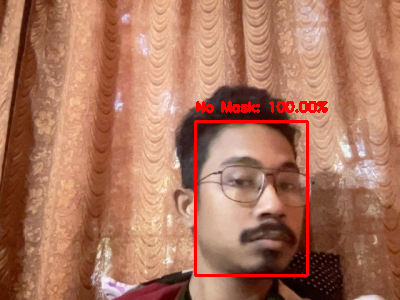

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 22ms/step


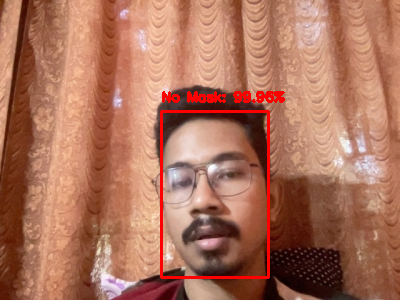

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 22ms/step


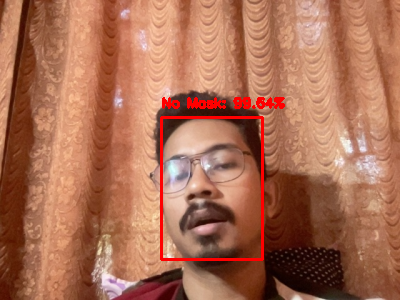

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 19ms/step


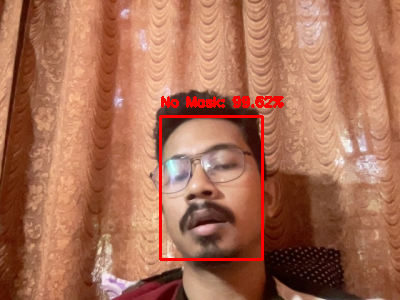

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 20ms/step


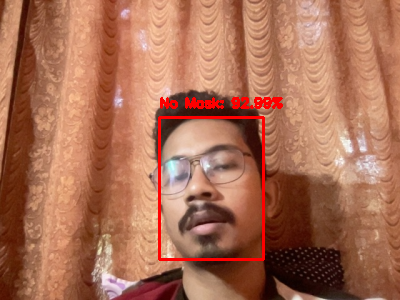

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 19ms/step


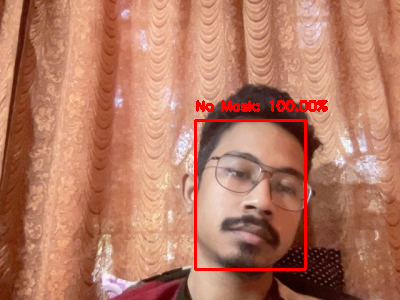

(1, 1, 200, 7)
(1, 1, 200, 7)
1/1 [==============================] - 0s 21ms/step


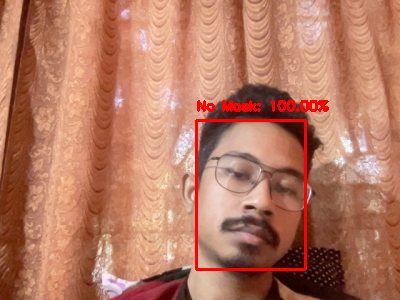

In [9]:
# initialize the video stream
print("[INFO] starting video stream...")
cap=video_stream()

# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
# bbox = ''
count = True
bbox=''
img_array = []

		# loop over the frames from the video stream

while True:

	js_reply = video_frame(label_html, bbox)
	if not js_reply:
		 break
		

	# convert JS response to OpenCV Image
	img = js_to_image(js_reply["img"])
	img = imutils.resize(img, width=400)

	#displaying "No Person" when no person in the vedio
	#detect person is present or not
	presence=detect_face(img,faceNet)
	if presence==0:
		cv2.putText(img, "No Person", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 255), 2)
 
		# detect faces in the frame and determine if they are wearing a face mask or not
	(locs, preds) = detect_and_predict_mask(img, faceNet, maskNet)
	

	# loop over the detected face locations and their corresponding locations
	for (box, pred) in zip(locs, preds):
		# unpack the bounding box and predictions
		(startX, startY, endX, endY) = box
		(mask, withoutMask) = pred


# determine the class label and color we'll use to draw the bounding box and text
		label = "Mask" if mask > withoutMask else "No Mask"
		color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

# include the probability in the label
		label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)
	

# display the label and bounding box rectangle on the output
# frame
		cv2.putText(img, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
		cv2.rectangle(img, (startX, startY), (endX, endY), color, 2)
	


#displaying ”Maintain Social Distancing” when two persons are standing close enough.

	# (locations,) = measure_distance(img,faceNet)
	# if(abs(locations[0][0]-locations[1][0])<100):
	# 	cv2.putText(img, "Maintain social distancing", (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 2)






# show the output frame
	from google.colab.patches import cv2_imshow
	cv2_imshow(img)
	img_array.append(img)
	key = cv2.waitKey(1) & 0xFF


	if key == ord("q"):
				break

In [10]:
# write the vedio
frame_width = 400
frame_height = 300

# Define the codec and create VideoWriter object.
out_avi = cv2.VideoWriter('race_car_out.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))

out_mp4 = cv2.VideoWriter('race_car_out.mp4',cv2.VideoWriter_fourcc(*'XVID'), 10, (frame_width,frame_height))
 

In [11]:
# Read until video is completed
bbox=''
while(cap):
  # Capture frame-by-frame
  js_reply = video_frame(label_html, bbox)
  if not js_reply:
		 break
  img = js_to_image(js_reply["img"])
    
  if img == True:
    
    # Write the frame to the output files
    out_avi.write(img)
    out_mp4.write(img)
    
  # Break the loop
  else: 
    break

# Writing photos to vedio

In [13]:
for i in range(len(img_array)):
  cv2.imwrite('img'+str(i)+'.jpg',img_array[i])
print("photos exported successfully")

photos exported successfully


In [14]:
#making the vedio
import cv2
import numpy as np
import glob

frameSize = (400, 300)

out = cv2.VideoWriter('output_video1.avi',cv2.VideoWriter_fourcc(*'DIVX'), 10, frameSize)

for filename in glob.glob('/content/drive/MyDrive/face mask detection/photos captued/*.jpg'):
    img = cv2.imread(filename)
    out.write(img)

out.release()
print("Video made successfully")

Video made successfully
